In [1]:
import numpy as np
import matplotlib.pyplot as plt
import keras
import cv2
from keras.models import Sequential
#from keras.optimizers import Adam
from keras.layers import Dense
from keras.utils.np_utils import to_categorical
from keras.layers import Dropout, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D
import pickle
import random
import pandas as pd

In [2]:
np.random.seed(0)

In [3]:
!git clone https://bitbucket.org/jadslim/german-traffic-signs

Cloning into 'german-traffic-signs'...
Unpacking objects: 100% (6/6), done.


In [4]:
with open('german-traffic-signs/train.p','rb') as f:
    train_data = pickle.load(f)
with open('german-traffic-signs/valid.p','rb') as f:
    val_data = pickle.load(f)  
with open('german-traffic-signs/test.p','rb') as f:
    test_data = pickle.load(f)

In [5]:
X_train, y_train = train_data['features'], train_data['labels']
X_val, y_val = val_data['features'], val_data['labels']
X_test, y_test = test_data['features'], test_data['labels']

In [6]:
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(34799, 32, 32, 3)
(4410, 32, 32, 3)
(12630, 32, 32, 3)


In [7]:
assert(X_train.shape[0] == y_train.shape[0]), "The number of images is not equal to the number of labels"
assert(X_val.shape[0] == y_val.shape[0]), "The number of images is not equal to the number of labels"
assert(X_test.shape[0] == y_test.shape[0]), "The number of images is not equal to the number of labels"
assert(X_train.shape[1:] == (32, 32, 3)), "The dimensions of the image is not 32*32*3"
assert(X_val.shape[1:] == (32, 32, 3)), "The dimensions of the image is not 32*32*3"
assert(X_test.shape[1:] == (32, 32, 3)), "The dimensions of the image is not 32*32*3"

VISUALIZING DATA


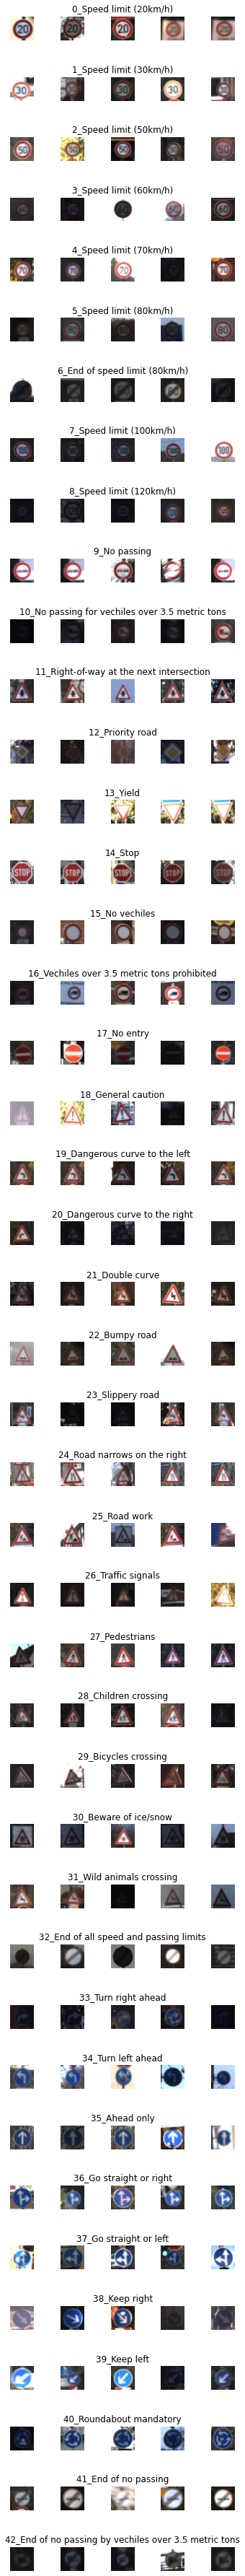

In [8]:
data = pd.read_csv('german-traffic-signs/signnames.csv')

num_of_samples = []

cols = 5
num_classes = 43

fig, axs = plt.subplots(nrows = num_classes, ncols = cols, figsize = (5, 50))
fig.tight_layout()

for i in range(cols):
    for j, row in data.iterrows():
        x_selected = X_train[y_train == j]
        axs[j][i].imshow(x_selected[random.randint(0, (len(x_selected)-1)), :, :], cmap = plt.get_cmap("gray"))
        axs[j][i].axis("off")
        if i == 2:
            axs[j][i].set_title(str(j) + "_" + row["SignName"])
            num_of_samples.append(len(x_selected))

[180, 1980, 2010, 1260, 1770, 1650, 360, 1290, 1260, 1320, 1800, 1170, 1890, 1920, 690, 540, 360, 990, 1080, 180, 300, 270, 330, 450, 240, 1350, 540, 210, 480, 240, 390, 690, 210, 599, 360, 1080, 330, 180, 1860, 270, 300, 210, 210]


Text(0, 0.5, 'Number of images')

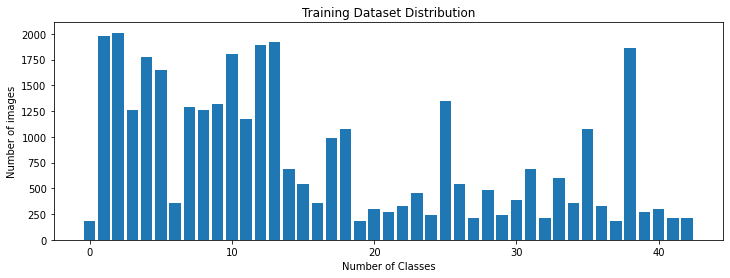

In [9]:
print(num_of_samples)
plt.figure(figsize = (12, 4))
plt.bar(range(0, num_classes), num_of_samples)
plt.title("Training Dataset Distribution")
plt.xlabel("Number of Classes")
plt.ylabel("Number of images")

Data Preprocessing

(32, 32, 3)
41
class name: 41
class name: End of no passing


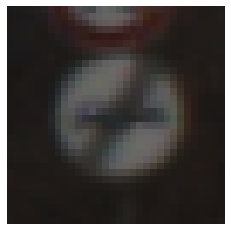

In [10]:
plt.imshow(X_train[2])
plt.axis('off')
print(X_train[2].shape)
print(y_train[2])
for num, name in data.iteritems():
  name = name.values
  print("class name: "+ str(name[y_train[2]]))


In [11]:
def grayscale(img):
    image = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    plt.axis('off')
    return image

(32, 32)


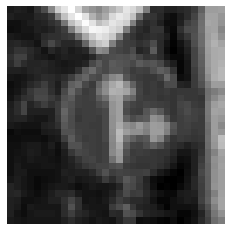

In [12]:
img = grayscale(X_train[1000])
plt.imshow(img, cmap = 'gray')
print(img.shape)

In [13]:
def equalize(img):
    img = cv2.equalizeHist(img)
    return img

(32, 32)


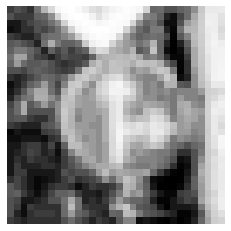

In [14]:
img = equalize(img)
plt.imshow(img, cmap = 'gray')
plt.axis('off')
print(img.shape)

In [15]:
def preprocessing(img):
    img = grayscale(img)
    img = equalize(img)
    img = img/255
    return img

In [ ]:
X_train = np.array(list(map(preprocessing, X_train)))
X_val = np.array(list(map(preprocessing, X_val)))
X_test = np.array(list(map(preprocessing, X_test)))

In [17]:
print(X_train.shape,X_val.shape,X_test.shape)
X_train = X_train.reshape(34799, 32, 32, 1)
X_val = X_val.reshape(4410, 32, 32, 1)
X_test = X_test.reshape(12630, 32, 32, 1)
print(X_train.shape,X_val.shape,X_test.shape)

(34799, 32, 32) (4410, 32, 32) (12630, 32, 32)
(34799, 32, 32, 1) (4410, 32, 32, 1) (12630, 32, 32, 1)


In [18]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(width_shift_range = 0.1,
                  height_shift_range = 0.1,
                   zoom_range = 0.2,
                  shear_range = 0.1,
                  rotation_range = 10)

datagen.fit(X_train)

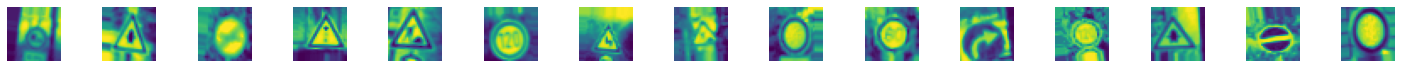

In [19]:
batches = datagen.flow(X_train, y_train, batch_size = 20)
X_batch, y_batch = next(batches)

fig, axs = plt.subplots(1, 15, figsize = (20, 5))
fig.tight_layout()

for i in range(15):
  axs[i].imshow(X_batch[i].reshape(32, 32))
  axs[i].axis('off')

In [20]:
y_train = to_categorical(y_train, 43)
y_val = to_categorical(y_val, 43)
y_test = to_categorical(y_test, 43)

In [29]:
def neural_model():
    model = Sequential()
    model.add(Conv2D(filters=32, kernel_size=(5, 5), input_shape = X_train.shape[1:], activation = 'relu'))
    model.add(Conv2D(filters=32, kernel_size=(5, 5), activation = 'relu'))
    model.add(MaxPooling2D(pool_size = (2,2)))
    model.add(Dropout(0.25))
    model.add(Conv2D(filters=64, kernel_size=(3, 3), activation = 'relu'))
    model.add(Conv2D(filters=64, kernel_size=(3, 3), activation = 'relu'))
    model.add(MaxPooling2D(pool_size = (2, 2)))
    
    model.add(Dropout(0.25))
    # opt = keras.optimizers.Adam(learning_rate=0.01)
    model.add(Flatten())
    model.add(Dense(256, activation = 'relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation = 'softmax'))
    model.compile(optimizer='adam', loss = 'categorical_crossentropy', metrics = ['acc'])
    return model

In [30]:
model = neural_model()
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 28, 28, 32)        832       
                                                                 
 conv2d_5 (Conv2D)           (None, 24, 24, 32)        25632     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 12, 12, 32)       0         
 2D)                                                             
                                                                 
 dropout_3 (Dropout)         (None, 12, 12, 32)        0         
                                                                 
 conv2d_6 (Conv2D)           (None, 10, 10, 64)        18496     
                                                                 
 conv2d_7 (Conv2D)           (None, 8, 8, 64)          36928     
                                                      

In [31]:
history=model.fit(X_train,y_train, batch_size=64,epochs=10, validation_data=(X_test,y_test))

Epoch 1/10
544/544 [==============================] - 8s 14ms/step - loss: 1.1759 - acc: 0.6715 - val_loss: 0.2247 - val_acc: 0.9371
Epoch 2/10
544/544 [==============================] - 7s 13ms/step - loss: 0.2223 - acc: 0.9308 - val_loss: 0.1720 - val_acc: 0.9489
Epoch 3/10
544/544 [==============================] - 7s 13ms/step - loss: 0.1333 - acc: 0.9581 - val_loss: 0.1542 - val_acc: 0.9525
Epoch 4/10
544/544 [==============================] - 7s 13ms/step - loss: 0.1055 - acc: 0.9674 - val_loss: 0.1406 - val_acc: 0.9617
Epoch 5/10
544/544 [==============================] - 7s 13ms/step - loss: 0.0911 - acc: 0.9717 - val_loss: 0.1435 - val_acc: 0.9584
Epoch 6/10
544/544 [==============================] - 7s 13ms/step - loss: 0.0756 - acc: 0.9759 - val_loss: 0.1384 - val_acc: 0.9614
Epoch 7/10
544/544 [==============================] - 7s 13ms/step - loss: 0.0661 - acc: 0.9787 - val_loss: 0.1088 - val_acc: 0.9712
Epoch 8/10
544/544 [==============================] - 7s 13ms/step - 

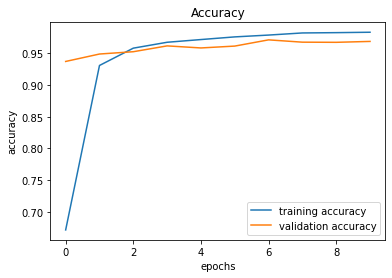

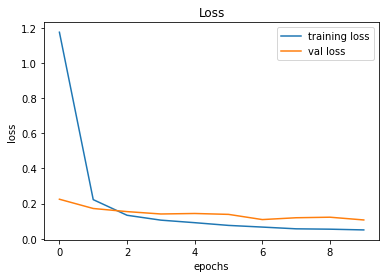

In [32]:
# plt.plot(history.history['loss'])

# plt.plot(history.history['acc'])
# plt.legend(['loss','Accuracy'])
# plt.title('Loss & Accuracy')
# plt.xlabel('epoch')

plt.figure(0)
plt.plot(history.history['acc'],label='training accuracy')
plt.plot(history.history['val_acc'],label='validation accuracy')
plt.title('Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()

plt.figure(1)
plt.plot(history.history['loss'],label='training loss')
plt.plot(history.history['val_loss'],label='val loss')
plt.title('Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()

In [33]:
score = model.evaluate(X_test, y_test, verbose = 1)
print('Test Score', score[0])
print('Test Accuracy', score[1])

395/395 [==============================] - 2s 5ms/step - loss: 0.1066 - acc: 0.9687
Test Score 0.10662894695997238
Test Accuracy 0.9687252640724182


## TESTING

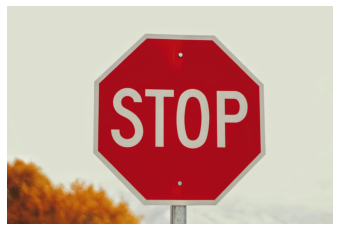

In [34]:
import requests
from PIL import Image
# url = 'https://c8.alamy.com/comp/A0RX23/cars-and-automobiles-must-turn-left-ahead-sign-A0RX23.jpg'
url = 'https://images.unsplash.com/photo-1572670014853-1d3a3f22b40f?ixid=MnwxMjA3fDB8MHxzZWFyY2h8MXx8c3RvcCUyMHNpZ258ZW58MHx8MHx8&ixlib=rb-1.2.1&w=1000&q=80'

r = requests.get(url, stream=True)
image = Image.open(r.raw)
plt.axis('off')
plt.imshow(image, cmap=plt.get_cmap('gray'))

(32, 32)


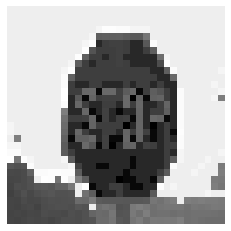

In [35]:
img = np.asarray(image)
img = cv2.resize(img, (32, 32))
img = preprocessing(img)
plt.imshow(img, cmap = plt.get_cmap('gray'))
print(img.shape)
img = img.reshape(1, 32, 32, 1)

In [36]:
predictions=model.predict(img) 

In [37]:
np.argmax(predictions)

14

predicted sign: 14
predicted sign: Stop


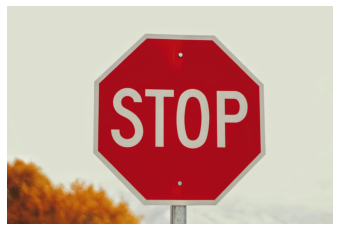

In [38]:
pred = np.argmax(predictions)
plt.imshow(image)
plt.axis('off')

for num, name in data.iteritems():
  name = name.values
  print("predicted sign: "+ str(name[pred]))

In [39]:
model.save('traffic_classifier.h5')

(32, 32)
predicted sign: 14
predicted sign: Stop
Label of the sign:  Stop


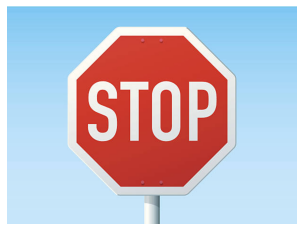

In [40]:
#@title Traffic sign classifier
#@markdown Enter Url of the traffic sign image to be classified

URL = 'https://media.istockphoto.com/vectors/stop-german-road-sign-vector-id453986857?k=20&m=453986857&s=612x612&w=0&h=uOgoEtPwB-mY6jLl7mEBMkeKFixEfRao9rhsnKzNL1A=' #@param {type:"string"}

Class = "Stop" #@param {type:"string"}



# getting image 

import requests
from PIL import Image
# url = 'https://c8.alamy.com/comp/A0RX23/cars-and-automobiles-must-turn-left-ahead-sign-A0RX23.jpg'
url = 'https://images.unsplash.com/photo-1572670014853-1d3a3f22b40f?ixid=MnwxMjA3fDB8MHxzZWFyY2h8MXx8c3RvcCUyMHNpZ258ZW58MHx8MHx8&ixlib=rb-1.2.1&w=1000&q=80'

r = requests.get(URL, stream=True)
image = Image.open(r.raw)
plt.axis('off')
plt.imshow(image, cmap=plt.get_cmap('gray'))

#Processing image
img = np.asarray(image)
img = cv2.resize(img, (32, 32))
img = preprocessing(img)
plt.imshow(img, cmap = plt.get_cmap('gray'))
print(img.shape)
img = img.reshape(1, 32, 32, 1)

#making predictions
predictions=model.predict(img) 
pred = np.argmax(predictions)
plt.imshow(image)
plt.axis('off')

for num, name in data.iteritems():
  name = name.values
  print("predicted sign: "+ str(name[pred]))

print("Label of the sign: ",Class)


In [42]:
!pip install --quiet gradio

     |████████████████████████████████| 979 kB 3.7 MB/s 
     |████████████████████████████████| 206 kB 45.4 MB/s 
     |████████████████████████████████| 2.0 MB 32.5 MB/s 
     |████████████████████████████████| 961 kB 39.7 MB/s 
     |████████████████████████████████| 3.6 MB 19.3 MB/s 
     |████████████████████████████████| 63 kB 2.3 MB/s 


In [43]:
import gradio as gr

In [44]:
response = requests.get("https://git.io/JPmou")
labels = response.text.split("\n")

def classify_image(inp):
  
    img = np.asarray(inp)
    img = cv2.resize(img, (32, 32))
    img = preprocessing(img)
    print(img.shape)
    img = img.reshape(1, 32, 32, 1)
    plt.imshow(inp)
    predictions=model.predict(img) 
    pred = np.argmax(predictions)
    return name[pred]

In [45]:
image = gr.inputs.Image(shape=(32,32))
label = gr.outputs.Label(num_top_classes=3)

gr.Interface(
    classify_image, 
    image, 
    label,
    capture_session=True).launch();

Colab notebook detected. To show errors in colab notebook, set `debug=True` in `launch()`
Running on public URL: https://44308.gradio.app

This share link will expire in 72 hours. To get longer links, send an email to: support@gradio.app
